<a href="https://colab.research.google.com/github/taiman9/Natural-language-processing/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow served using Flask

---

## Task 1: Introduction

In this project, I process the tweet emotion dataset, build a deep learning model to detect tweet sentiment, train and evaluate my model on the tweet emotion dataset and finally serve my tweet sentiment model using a Flask web app.

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 243 kB 48.6 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=150000, oov_token='<UNK.')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

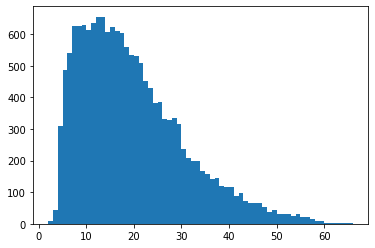

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
print(classes)

{'love', 'joy', 'anger', 'surprise', 'fear', 'sadness'}


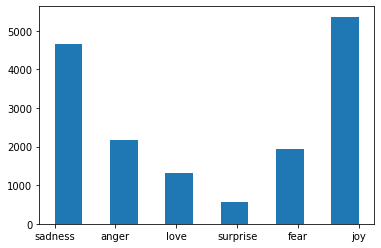

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 2, 'fear': 4, 'joy': 1, 'love': 0, 'sadness': 5, 'surprise': 3}

In [ ]:
index_to_class

{0: 'love', 1: 'joy', 2: 'anger', 3: 'surprise', 4: 'fear', 5: 'sadness'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(20, activation='relu'), 
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')                            
])

model.compile(
  
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 20)                820       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 176,626
Trainable params: 176,626
Non-trainable params: 0
__________________________________________________

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model using k-fold cross validation

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [ ]:
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True)

acc_per_fold, loss_per_fold = [],[]

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(padded_train_seq, train_labels):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  h = model.fit(
  padded_train_seq[train], train_labels[train],
  validation_data=(val_seq, val_labels),
  epochs=20,
  callbacks=[
             tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
            ]
  )

  # Generate generalization metrics
  scores = model.evaluate(padded_train_seq[test], train_labels[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
334/334 [==============================] - 29s 54ms/step - loss: 1.5876 - accuracy: 0.3181 - val_loss: 1.3822 - val_accuracy: 0.4040
Epoch 2/20
334/334 [==============================] - 16s 48ms/step - loss: 1.1834 - accuracy: 0.4827 - val_loss: 1.0031 - val_accuracy: 0.6175
Epoch 3/20
334/334 [==============================] - 16s 48ms/step - loss: 0.7875 - accuracy: 0.7220 - val_loss: 0.7569 - val_accuracy: 0.7385
Epoch 4/20
334/334 [==============================] - 16s 49ms/step - loss: 0.5384 - accuracy: 0.8128 - val_loss: 0.7842 - val_accuracy: 0.7455
Epoch 5/20
334/334 [==============================] - 16s 48ms/step - loss: 0.4352 - accuracy: 0.8389 - val_loss: 0.7192 - val_accuracy: 0.7565
Epoch 6/20
334/334 [==============================] - 16s 48ms/step - loss: 0.3629 - accuracy: 0.8610 - val_loss: 0.6643 - val_accuracy: 0.7965
Epoch 7/20
334/334 [===================

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

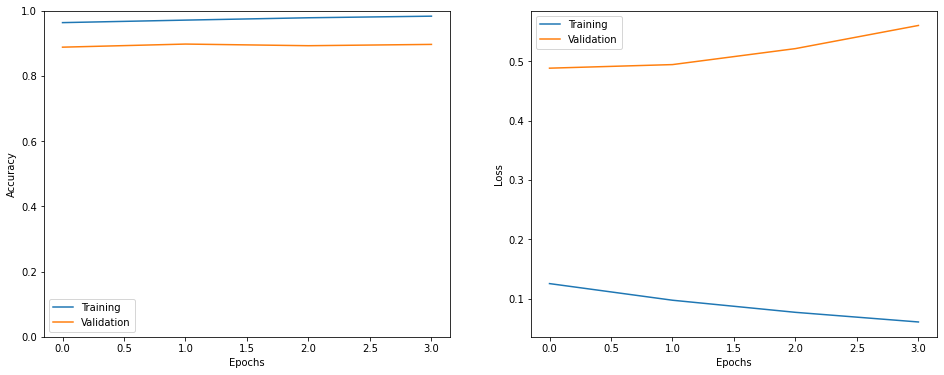

In [ ]:
# Training history for last cross validation fold
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(dataset['test'])
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.5789 - accuracy: 0.8865


In [ ]:
i = random.randint(0, len(test_labels) - 2)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
#print(np.expand_dims(test_seq[i], axis=0))

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print(type(pred_class))                        
print('Predicted emotion:', pred_class)

Sentence: i feel so heartbroken over paul walker s tragic disappearance the life of someone so generous beautiful and talented should not end this way as other horrible individuals keep on living torturing assaulting and killing people
Emotion: sadness
<class 'str'>
Predicted emotion: sadness


In [ ]:
preds = np.argmax(model.predict(test_seq), axis=1)

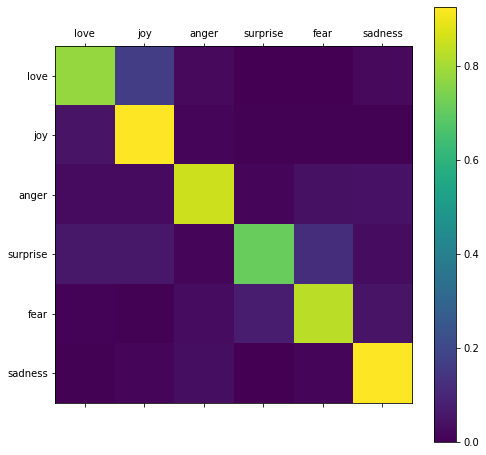

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))

Upoad the *templates* and *static* folders and run the following to unzip them

In [ ]:
!unzip templates.zip

Archive:  templates.zip
   creating: templates/
  inflating: templates/home.html     
  inflating: templates/result.html   


In [ ]:
!unzip static.zip
!ls

Archive:  static.zip
   creating: static/
   creating: static/styles/
sample_data  static  static.zip  templates  templates.zip


## Task 10: Serving your model using a Flask Web API

Open the Flask web app created by running the cells below to enter a tweet and receive your model's predicted sentiment of the tweet.

In [ ]:
!pip install flask-ngrok

from flask import Flask,render_template,url_for,request
from flask_ngrok import run_with_ngrok
import pandas as pd 
import pickle
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/')
def home():
	return render_template('home.html')
 
@app.route('/predict',methods=['POST'])
def predict():
	#Alternative Usage of Saved Model
	# joblib.dump(clf, 'NB_spam_model.pkl')
	# NB_spam_model = open('NB_spam_model.pkl','rb')
	# clf = joblib.load(NB_spam_model)

	if request.method == 'POST':
		message = request.form['message']
		data = [message]
		sent_seq = tokenizer.texts_to_sequences(data)
		padded_seq = pad_sequences(sent_seq, truncating='post', padding='post', maxlen=maxlen)
		p = model.predict(np.expand_dims(padded_seq[0], axis=0))[0]
		pred_class = index_to_class[np.argmax(p).astype('uint8')]
	return render_template('result.html',prediction = pred_class)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://77a1-34-136-143-216.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/Nov/2021 08:14:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Nov/2021 08:14:32] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [03/Nov/2021 08:14:32] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [03/Nov/2021 08:14:55] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [03/Nov/2021 08:14:55] "GET /static/css/styles.css HTTP/1.1" 404 -
